# XMM-13hr master catalogue
## Preparation of UKIRT Hemisphere Survey (UHS) data

The catalogue comes from `dmu0_UHS`. This is a J band only survey documented in https://arxiv.org/pdf/1707.09975.pdf

In the catalogue, we keep:

- The identifier (it's unique in the catalogue);
- The position;
- The stellarity;
- The magnitude for each band in aperture 4 (2 arcsec aperture corrected).
- The kron magnitude to be used as total magnitude (no “auto” magnitude is provided).

We don't know when the maps have been observed. We will use the year of the reference paper.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
04829ed (Thu Nov 2 16:57:19 2017 +0000)


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux

In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "uhs_ra"
DEC_COL = "uhs_dec"

## I - Column selection

In [4]:
imported_columns = OrderedDict({
        'SOURCEID': "uhs_id",
        'RA': "uhs_ra",
        'DEC': "uhs_dec",
        'PSTAR':  "uhs_stellarity",
        'JPETROMAG': "m_wfcam_j", 
        'JPETROMAGERR': "merr_wfcam_j", 
        'JAPERMAG4': "m_ap_wfcam_j", 
        'JAPERMAG4ERR': "merr_ap_wfcam_j", 

    })


catalogue = Table.read("../../dmu0/dmu0_UHS/data/UHS-DR1_XMM-13hr.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2011

# Clean table metadata
catalogue.meta = None

In [5]:
#Vega to AB
#Vega ZPT (1548.66 Jy) from http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?id=UKIRT/WFCAM.J

vega_to_ab = {
    "j": -2.5*np.log10(1548.66 / 3631)
}
print(vega_to_ab["j"])

0.925175419285


In [6]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('m_'):
        
        errcol = "merr{}".format(col[1:])
        
        # Some object have a magnitude to 0, we suppose this means missing value
        catalogue[col][catalogue[col] <= 0] = np.nan
        catalogue[errcol][catalogue[errcol] <= 0] = np.nan  
        
        # Convert magnitude from Vega to AB
        catalogue[col] += vega_to_ab[col[-1]]

        flux, error = mag_to_flux(np.array(catalogue[col]), np.array(catalogue[errcol]))
        
        # Fluxes are added in µJy
        catalogue.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        catalogue.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))
        
        # Band-flag column
        if "ap" not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


In [7]:
catalogue[:10].show_in_notebook()

idx,uhs_id,uhs_ra,uhs_dec,uhs_stellarity,m_wfcam_j,merr_wfcam_j,m_ap_wfcam_j,merr_ap_wfcam_j,f_wfcam_j,ferr_wfcam_j,flag_wfcam_j,f_ap_wfcam_j,ferr_ap_wfcam_j
,,deg,deg,,,,,,,,,,
0,459621206470,203.144709071,38.2140207744,0.00306749,19.3204,0.182334,19.8994,0.160211,67.8939,11.4018,False,39.8311,5.87747
1,459621206476,203.148579228,38.2101019679,0.993865,14.7341,0.00350534,14.728,0.00282313,4638.32,14.975,False,4664.54,12.1287
2,459621206478,203.224484006,38.2079822598,0.00306749,19.2365,0.182846,19.1677,0.0829127,73.3492,12.3526,False,78.1475,5.96777
3,459621206484,203.22022099,38.2055999748,0.00306749,20.3401,0.465671,19.8166,0.148913,26.5443,11.3848,False,42.9901,5.89625
4,459621206490,203.170785083,38.203062631,0.00306749,19.2261,0.167351,19.8507,0.153367,74.0582,11.415,False,41.6611,5.8849
5,459621206499,203.216362751,38.1991879254,0.00306749,20.2498,0.362802,20.1903,0.209289,28.8467,9.63919,False,30.4714,5.87374
6,459621206500,203.20391246,38.198962094,0.00306749,19.5233,0.220066,19.6835,0.13201,56.3232,11.4161,False,48.5971,5.90872
7,459621206505,203.200348742,38.1957272546,0.00306749,19.5455,0.212503,19.5379,0.115741,55.1813,10.8002,False,55.5703,5.92387
8,459621206510,203.191492816,38.1922951841,0.00306749,19.0041,0.182926,19.5416,0.116109,90.8547,15.3073,False,55.3821,5.92257


## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [8]:
SORT_COLS = ['merr_ap_wfcam_j']
FLAG_NAME = 'uhs_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


The initial catalogue had 7879 sources.
The cleaned catalogue has 7186 sources (693 removed).
The cleaned catalogue has 666 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [9]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_XMM-13hr.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

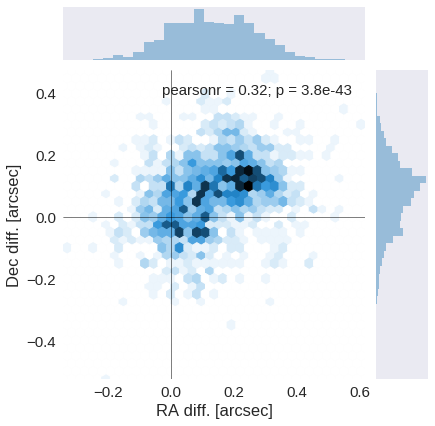

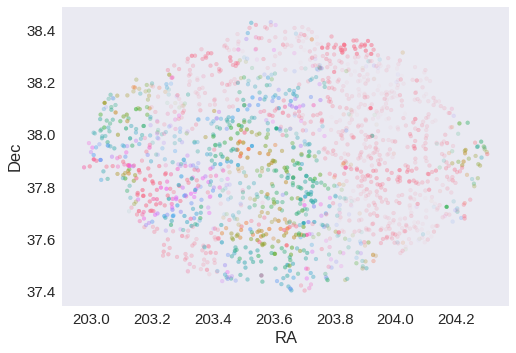

In [10]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [11]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: -0.12516495181102982 arcsec
Dec correction: -0.082956100101228 arcsec


In [12]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

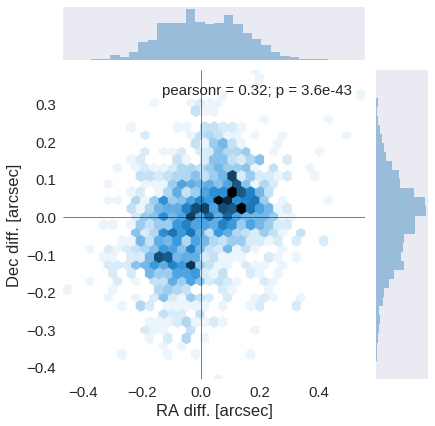

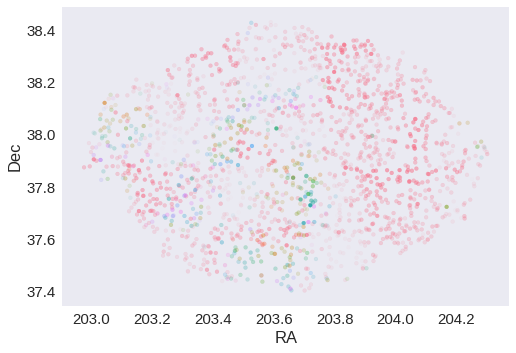

In [13]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [14]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [15]:
GAIA_FLAG_NAME = "uhs_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

1733 sources flagged.


# V - Saving to disk

In [16]:
catalogue.write("{}/UHS.fits".format(OUT_DIR), overwrite=True)